# PPE analysis template
- Daniel Kennedy (djk2120@ucar.edu)
- updated January 23, 2022
- note that there are dependencies to other files in the repo

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

/glade/work/kdagon/miniconda/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# for plotting maps
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [3]:
### import some analysis functions we wrote for this project
###  note that you can inspect the code for these functions in ../ppe_tools/analysis.py
import sys ; sys.path.append("..")
from ppe_tools.analysis import *

In [35]:
# reimport ppe_tools.analysis if working on it interactively
import ppe_tools.analysis
from ppe_tools.analysis import *
import importlib
importlib.reload(ppe_tools.analysis)

<module 'ppe_tools.analysis' from '../ppe_tools/analysis.py'>

### optional: set up your PBSCluster
- not necessary if you are working with preprocessed data
- client.cluster will show when your workers are active
- note it can take a few minutes to get through the job queue
- set up to ask for 1hr, but can be increased

In [9]:
# Setup your PBSCluster

project = 'P06010014' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42084 instead
  f"Port {expected} is already in use.\n"


In [10]:
# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

In [11]:
## wait until workers >0
client.cluster

In [76]:
# close when done
cluster.close()

### Define some info about the ensemble

In [4]:
#define the directory structure to find files
def get_files(name,htape,keys):
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]
    return files

In [5]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/surv.csv' 
paramkey = pd.read_csv(csv)
keys = paramkey.key

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

#load conversion factors
attrs = pd.read_csv('agg_units.csv',index_col=0)

In [6]:
keys

0      OAAT0000
1      OAAT0001
2      OAAT0002
3      OAAT0003
4      OAAT0004
         ...   
368    OAAT0460
369    OAAT0461
370    OAAT0469
371    OAAT0470
372    OAAT0471
Name: key, Length: 373, dtype: object

In [6]:
#empty dataset, can be useful to have around
p,m = get_params(keys,paramkey)
ds0 = xr.Dataset()
ds0['param']  =xr.DataArray(p,dims='ens')
ds0['minmax'] =xr.DataArray(m,dims='ens')
ds0['key']    =xr.DataArray(keys,dims='ens')
whit = xr.open_dataset('./whit/whitkey.nc')
ds0['biome']      = whit['biome']
ds0['biome_name'] = whit['biome_name']

In [8]:
ds0

<xarray.Dataset>
Dimensions:     (ens: 373, gridcell: 400, biome_id: 10)
Coordinates:
  * ens         (ens) int64 0 1 2 3 4 5 6 7 ... 365 366 367 368 369 370 371 372
  * gridcell    (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * biome_id    (biome_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    param       (ens) <U32 'default' 'taulnir' ... 'decomp_depth_efolding'
    minmax      (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
    key         (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0470' 'OAAT0471'
    biome       (gridcell) float64 ...
    biome_name  (biome_id) object ...

## Example analyses:
### Working with annual means, at the global/biome/pft levels
- we have a helper function for this purpose (calc_mean)
- it also saves & writes intermediate data so you don't have to recalculate every session

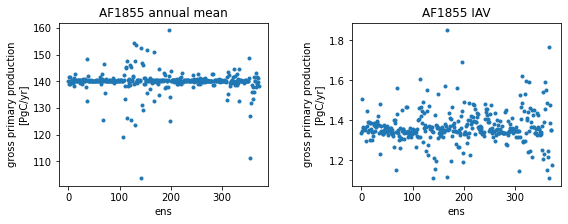

In [9]:
#global means, scatter plot
ens_name = 'AF1855'
datavar  = 'GPP'
domain   = 'global'
xmean,xiav = calc_mean(ens_name,datavar,la,attrs,ds0,domain=domain)

plt.figure(figsize=[9,3])
plt.subplot(121)
xmean.plot.line('.')
plt.title(ens_name+' annual mean')
plt.subplot(122)
xiav.plot.line('.')
plt.title(ens_name+' IAV')
plt.subplots_adjust(wspace=0.4)

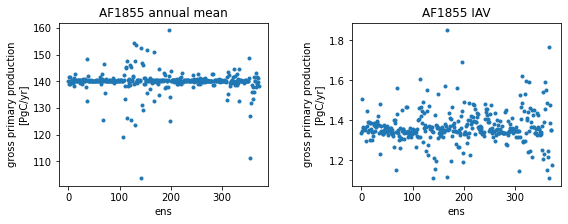

In [10]:
## how to save a figure
filename = '../figs/example.png'
plt.figure(figsize=[9,3])
plt.subplot(121)
xmean.plot.line('.')
plt.title(ens_name+' annual mean')
plt.subplot(122)
xiav.plot.line('.')
plt.title(ens_name+' IAV')
plt.subplots_adjust(wspace=0.4)
plt.savefig(filename)

#note you can examine the printed figure by navigating 
# to it in the left panel


In [53]:
# global mean LHF, histogram plots
ens_name = 'CTL2010'
datavar  = 'EFLX_LH_TOT'
domain   = 'global'
xmean,xiav = calc_mean(ens_name,datavar,la,attrs,ds0,domain=domain)
xmean.long_name

#plt.hist(xmean, bins=30)
#plt.hist(xiav, bins=30)

'total latent heat flux [+ to atm]'

In [28]:
paramkey

,key,param,minmax
0,OAAT0000,default,default
1,OAAT0001,taulnir,min
2,OAAT0002,taulnir,max
3,OAAT0003,taulvis,min
4,OAAT0004,taulvis,max
...,...,...,...
368,OAAT0460,clay_pf,min
369,OAAT0461,clay_pf,max
370,OAAT0469,zbedrock_sf,min
371,OAAT0470,zbedrock_sf,max


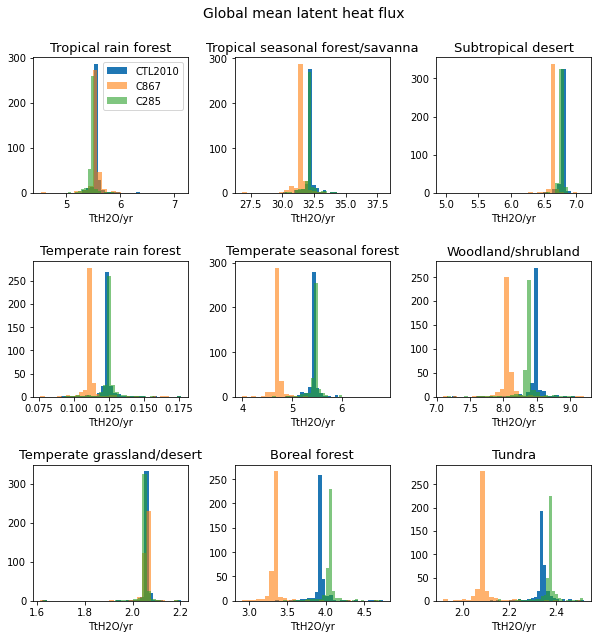

In [58]:
# panel biome distributions for CTL/C867/C285, LHF, MEAN
ens_name = 'CTL2010'
datavar  = 'EFLX_LH_TOT'
#datavar = 'EFLX_LH_TOT-TLAI'
domain   = 'biome'
keys = paramkey.key
xmean,xiav = calc_mean(ens_name,datavar,la,attrs,ds0,keys=keys,paramkey=paramkey,domain=domain)

ens_name2 = 'C867'
xmean2,xiav2 = calc_mean(ens_name2,datavar,la,attrs,ds0,keys=keys,paramkey=paramkey,domain=domain)

ens_name3 = 'C285'
xmean3,xiav3 = calc_mean(ens_name3,datavar,la,attrs,ds0,keys=keys,paramkey=paramkey,domain=domain)

fig, ax = plt.subplots(3, 3, figsize=(10,10))
axs = ax.ravel()

for b in range(1,len(xmean.biome)): # skip ice sheets (b=0)
    axs[b-1].hist(xmean.sel(biome=b), bins=30, color='C0', label=ens_name)
    axs[b-1].hist(xmean2.sel(biome=b), bins=30, color='C1', label=ens_name2, alpha=0.6)
    axs[b-1].hist(xmean3.sel(biome=b), bins=30, color='C2', label=ens_name3, alpha=0.6)
    bname=str(ds0.biome_name.sel(biome_id=b).values)
    axs[b-1].set_xlabel(xmean.units)
    axs[b-1].set_title(bname, fontsize=13);
    if b==1:
        axs[b-1].legend()
        
#fig.suptitle(xmean.long_name+', '+ens_name, fontsize=16, y=0.91)
#fig.suptitle('Global mean latent heat flux, '+ens_name, fontsize=16, y=0.91)
fig.suptitle('Global mean latent heat flux', fontsize=14, y=0.95)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
#plt.savefig('../figs/'+ens_name+'_'+datavar+'_'+domain+'_mean.png', bbox_inches='tight')
#plt.savefig('../figs/'+ens_name+'_'+ens_name2+'_'+ens_name3+'_'+datavar+'_'+domain+'_mean.png', bbox_inches='tight')

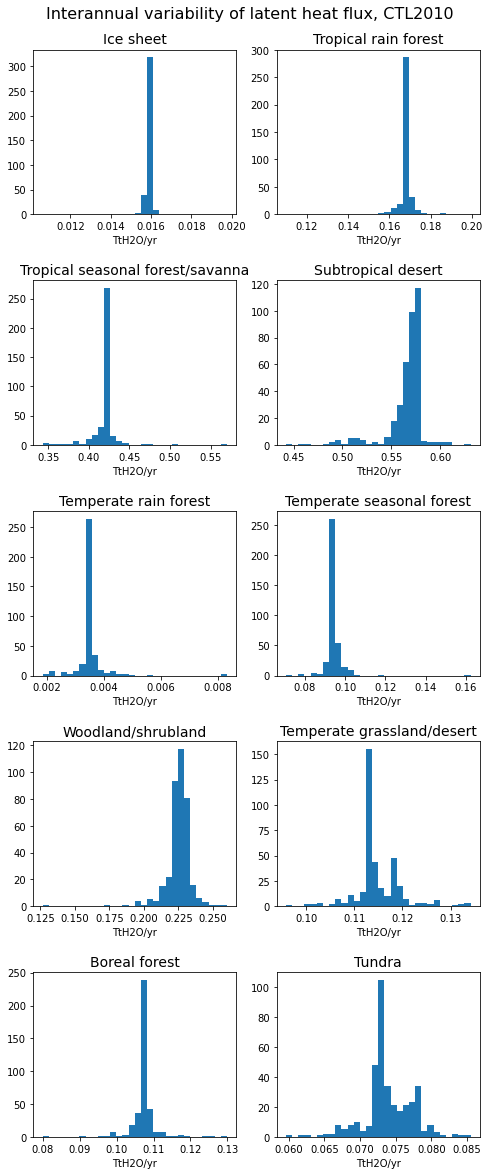

In [60]:
# panel biome distributions for CTL, LHF, IAV
ens_name = 'CTL2010'
datavar  = 'EFLX_LH_TOT'
domain   = 'biome'
xmean,xiav = calc_mean(ens_name,datavar,la,attrs,ds0,domain=domain)

fig, ax = plt.subplots(5, 2, figsize=(8,20))
axs = ax.ravel()

for b in range(len(xiav.biome)):
    axs[b].hist(xiav.sel(biome=b), bins=30)
    bname=str(ds0.biome_name.sel(biome_id=b).values)
    axs[b].set_xlabel(xiav.units)
    axs[b].set_title(bname, fontsize=14);

#fig.suptitle(xiav.long_name+', '+ens_name, fontsize=16, y=0.91)
fig.suptitle('Interannual variability of latent heat flux, '+ens_name, fontsize=16, y=0.91)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
#plt.savefig('../figs/CTL2010_EFLX_LH_TOT_biome_iav.png', bbox_inches='tight')

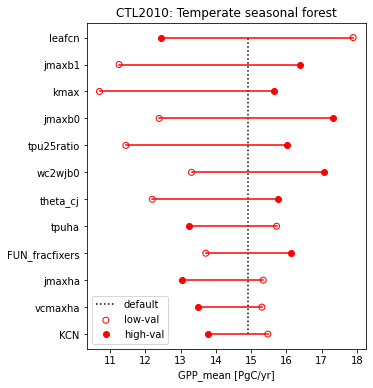

In [11]:
#biome mean, rank_plot

#calc biome-level annual means
ens_name = 'CTL2010'
datavar  = 'GPP'
domain   = 'biome'
xmean,xiav = calc_mean(ens_name,datavar,la,attrs,ds0,domain=domain)

#select the temperate seasonal forest biome
biome=5
bname=str(ds0.biome_name.sel(biome_id=biome).values)
da = xmean.sel(biome=biome)

#rank_plot will rank the parameters by their effects on the given datavar
plt.figure(figsize=[5,6])
rank_plot(da,ds0,12)
plt.title(ens_name+': '+bname);

In [12]:
##access the top_n without plotting
da = xmean.sel(biome=biome)
nx = 10
xmins,xmaxs,pvals=top_n(da,nx,ds0.param,ds0.minmax)
pvals[-1::-1]  #list is in reverse order

['leafcn',
 'jmaxb1',
 'kmax',
 'jmaxb0',
 'tpu25ratio',
 'wc2wjb0',
 'theta_cj',
 'tpuha',
 'FUN_fracfixers',
 'jmaxha']

### Work more directly with the output data
 - you'll probably want to activate the PBSCluster code from the beginning of the notebook 


In [68]:
#load the ensemble
#   monthly='h0', pft='h1', daily='h5'
keys  = paramkey.key
htape = 'h0'
name  = 'CTL2010'
files = get_files(name,htape,keys)
data_vars = ['GPP']
ds = get_ensemble(files,data_vars,keys,paramkey)

In [69]:
ds

<xarray.Dataset>
Dimensions:     (gridcell: 400, ens: 373, time: 120, biome_id: 10)
Coordinates:
  * gridcell    (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens         (ens) int64 0 1 2 3 4 5 6 7 ... 365 366 367 368 369 370 371 372
  * time        (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
  * biome_id    (biome_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    GPP         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    grid1d_lat  (gridcell) float64 ...
    grid1d_lon  (gridcell) float64 ...
    key         (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0470' 'OAAT0471'
    param       (ens) <U32 'default' 'taulnir' ... 'decomp_depth_efolding'
    minmax      (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
    biome       (gridcell) float64 ...
    biome_name  (biome_id) object ...
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/26/21 15:05:00
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn08_CTL2010_PROD_001.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### examine GPP, one ensemble member

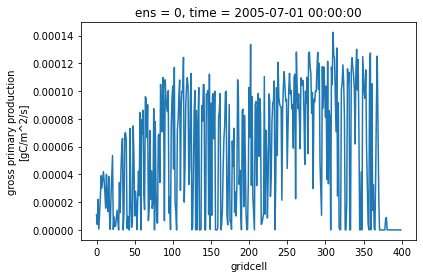

In [18]:
## note that the output is not global, but rather a subset of 400 meaningful pixels
##   so you can't plot a map directly
ds.GPP.isel(ens=0,time=6).plot();    #ens0 = default

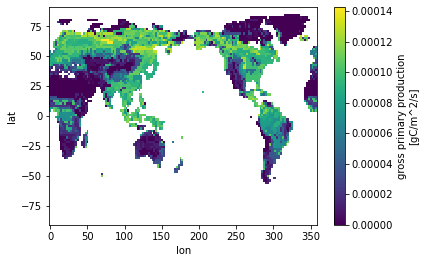

In [19]:
## but we have a function to map the sparsegrid to a global map: get_map
##   it is a little bit slow.....
da_map = get_map(ds.GPP.isel(ens=0,time=6))
da_map.plot();

In [20]:
help(get_map)

Help on function get_map in module ppe_tools.analysis:

get_map(da)
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...



In [72]:
ds.GPP.mean(dim='time')

<xarray.DataArray 'GPP' (ens: 373, gridcell: 400)>
dask.array<mean_agg-aggregate, shape=(373, 400), dtype=float32, chunksize=(1, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372

In [59]:
# look at some soil moisture maps
keys  = paramkey.key
htape = 'h0'
name  = 'CTL2010'
files = get_files(name,htape,keys)
data_vars = ['SOILWATER_10CM']
ds = get_ensemble(files,data_vars,keys,paramkey)

In [60]:
ds

<xarray.Dataset>
Dimensions:         (gridcell: 400, ens: 373, time: 120, biome_id: 10)
Coordinates:
  * gridcell        (gridcell) int64 0 1 2 3 4 5 6 ... 394 395 396 397 398 399
  * ens             (ens) int64 0 1 2 3 4 5 6 7 ... 366 367 368 369 370 371 372
  * time            (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
  * biome_id        (biome_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    SOILWATER_10CM  (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    grid1d_lat      (gridcell) float64 ...
    grid1d_lon      (gridcell) float64 ...
    key             (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0470' 'OAAT0471'
    param           (ens) <U32 'default' 'taulnir' ... 'decomp_depth_efolding'
    minmax          (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
    biome           (gridcell) float64 ...
    biome_name      (biome_id) object ...
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/26/21 15:05:00
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn08_CTL2010_PROD_001.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [61]:
ds.SOILWATER_10CM

<xarray.DataArray 'SOILWATER_10CM' (ens: 373, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(373, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372
  * time      (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Attributes:
    long_name:     soil liquid water + ice in top 10cm of soil (veg landunits...
    units:         kg/m2
    cell_methods:  time: mean

In [62]:
# this doesn't propogate the units forward
da_tmean = ds.SOILWATER_10CM.mean(dim='time')
da_tmean

<xarray.DataArray 'SOILWATER_10CM' (ens: 373, gridcell: 400)>
dask.array<mean_agg-aggregate, shape=(373, 400), dtype=float32, chunksize=(1, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372

In [64]:
# default map
df_map = get_map(da_tmean.isel(ens=0))
df_map

<xarray.DataArray 'SOILWATER_10CM' (lat: 96, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [66]:
da_max = da_tmean.max(dim='ens').persist()

In [67]:
dmax_map = get_map(da_max)

In [68]:
da_min = da_tmean.min(dim='ens').persist()
dmin_map = get_map(da_min)

In [70]:
# get bounds (but first need to figure out how to load in these maps)
df_map.max().values

array(86.94618988)

In [71]:
df_map.min().values

array(5.48134089)

In [73]:
dmax_map.max().values

array(87.68815613)

In [74]:
dmin_map.max().values

array(77.83370972)

AttributeError: 'LinearSegmentedColormap' object has no attribute 'get_array'

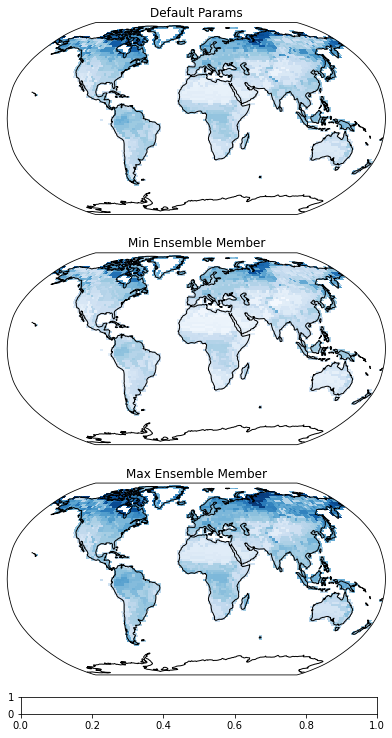

In [75]:
# try plotting the default, min, max ensemble members
fig, axs = plt.subplots(3, 1, figsize=(15,12), subplot_kw={'projection': ccrs.Robinson()})

cmap = plt.cm.get_cmap('Blues')
vmin = 0
vmax = 90

# default
field, lon = add_cyclic_point(df_map, coord=df_map.lon)
lat = df_map.lat
cf = axs[0].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()) 
axs[0].coastlines()
axs[0].set_title('Default Params')

# min
field, lon = add_cyclic_point(dmin_map, coord=dmin_map.lon)
lat = dmin_map.lat
cf = axs[1].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()) 
axs[1].coastlines()
axs[1].set_title('Min Ensemble Member')

# max
field, lon = add_cyclic_point(dmax_map, coord=dmax_map.lon)
lat = dmax_map.lat
cf = axs[2].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()) 
axs[2].coastlines()
axs[2].set_title('Max Ensemble Member')

# colorbar
cb_ax = fig.add_axes([0.35, 0.08, 0.33, 0.02])
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = matplotlib.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cbar.ax.set_xlabel('kg/m^2', fontsize=14)

fig.suptitle('Annual Mean 10cm Soil Moisture', fontsize=16, y=0.94)
plt.subplots_adjust(wspace=0, hspace=0.1)

### examine average GPP, all ensemble members

In [21]:
## the perturbations are described via ds.param, ds.minmax
for i in range(10):
    print(ds.param.sel(ens=i).values,ds.minmax.sel(ens=i).values )

default default
taulnir min
taulnir max
taulvis min
taulvis max
tausnir min
tausnir max
tausvis min
tausvis max
rholnir min


### look at a single gridcell

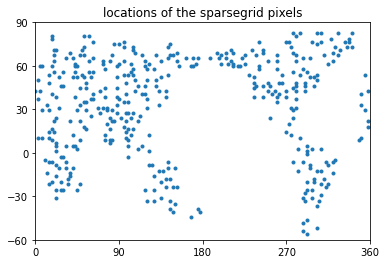

In [22]:
plt.plot(ds.grid1d_lon,ds.grid1d_lat,'.')
plt.xlim([0,360]); plt.xticks(90*np.arange(5))
plt.ylim([-60,90]); plt.yticks(-60+30*np.arange(6))
plt.title('locations of the sparsegrid pixels');

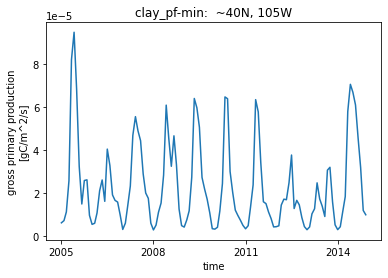

In [24]:
latn = 40
lonw = 105

lat = latn
lon = 360-lonw  #105W

#find nearest point
d = np.sqrt((ds.grid1d_lat-lat)**2+(ds.grid1d_lon-lon)**2)
ix = d==np.min(d)


   
#pick an ensemble member and plot
ee = 368
p = str(ds.param.isel(ens=ee).values)
m = str(ds.minmax.isel(ens=ee).values)

ds.GPP.isel(ens=ee,gridcell=ix).plot()
plt.title(p+'-'+m+':  ~'+str(latn)+'N, '+str(lonw)+'W');
    

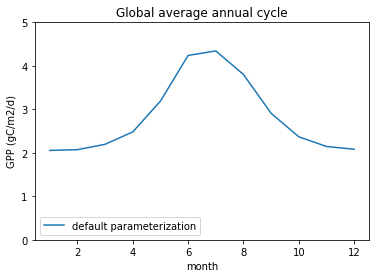

In [68]:
#compute the global annual cycle
cf1 = 24*60*60    #gc/m2/s -> /d
cf2 = 1/la.sum()
units = 'gC/m2/d'

datavar='GPP'
x = cf1*cf2*(la*ds[datavar]).sum(dim='gridcell').groupby('time.month').mean()

x.sel(ens=0).plot()
plt.ylim([0,5])
plt.ylabel(datavar+' ('+units+')')
plt.legend(['default parameterization'],loc=3)
plt.title('Global average annual cycle');

In [72]:
x

<xarray.DataArray (ens: 373, month: 12)>
dask.array<multiply, shape=(373, 12), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

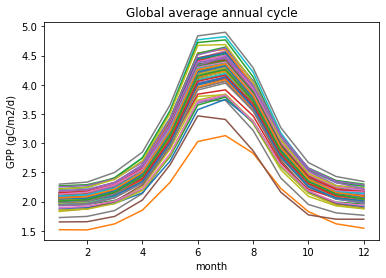

In [71]:
# look at the spread of annual cycles across ensemble members (control ensemble)

for e in x.ens:
    x.sel(ens=e).plot()
    #plt.ylim([0,5])

plt.ylabel(datavar+' ('+units+')')
#plt.legend(['default parameterization'],loc=3)
plt.title('Global average annual cycle');

In [77]:
# plot default param and spread
x_spread = x.std(dim='ens').persist()

In [79]:
x.sel(ens=0)

<xarray.DataArray (month: 12)>
dask.array<getitem, shape=(12,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    ens      int64 0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

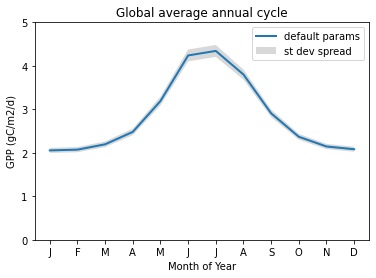

In [91]:
# std is actually quite small given distribution of ensemble members
plt.plot(x.month, x.sel(ens=0), linewidth=2, label='default params')
plt.fill_between(x.month, x.sel(ens=0)-x_spread, 
                x.sel(ens=0)+x_spread, alpha=0.3, facecolor='grey', label='st dev spread')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylim([0,5])
plt.ylabel(datavar+' ('+units+')')
plt.legend()
plt.title('Global average annual cycle');

(array([  1.,   1.,   1.,   4.,   4.,  14., 315.,  26.,   4.,   3.]),
 array([2.08522048, 2.19643442, 2.30764836, 2.4188623 , 2.53007624,
        2.64129019, 2.75250413, 2.86371807, 2.97493201, 3.08614595,
        3.19735989]),
 <BarContainer object of 10 artists>)

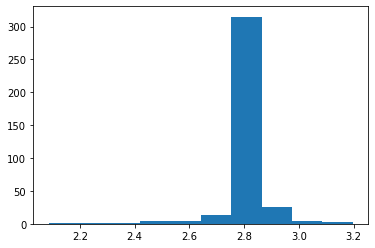

In [82]:
# spread across annual mean
plt.hist(x.mean(dim='month'));

In [83]:
x_min = x.min(dim='ens').persist()
x_max = x.max(dim='ens').persist()

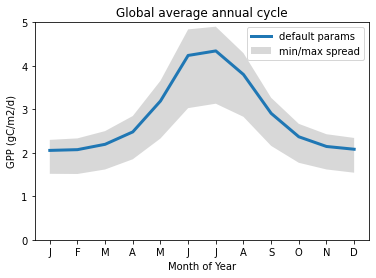

In [89]:
plt.plot(x.month, x.sel(ens=0), linewidth=3, label='default params')
plt.fill_between(x.month, x_min, 
                x_max, alpha=0.3, facecolor='grey', label='min/max spread')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylim([0,5])
plt.ylabel(datavar+' ('+units+')')
plt.legend()
plt.title('Global average annual cycle');

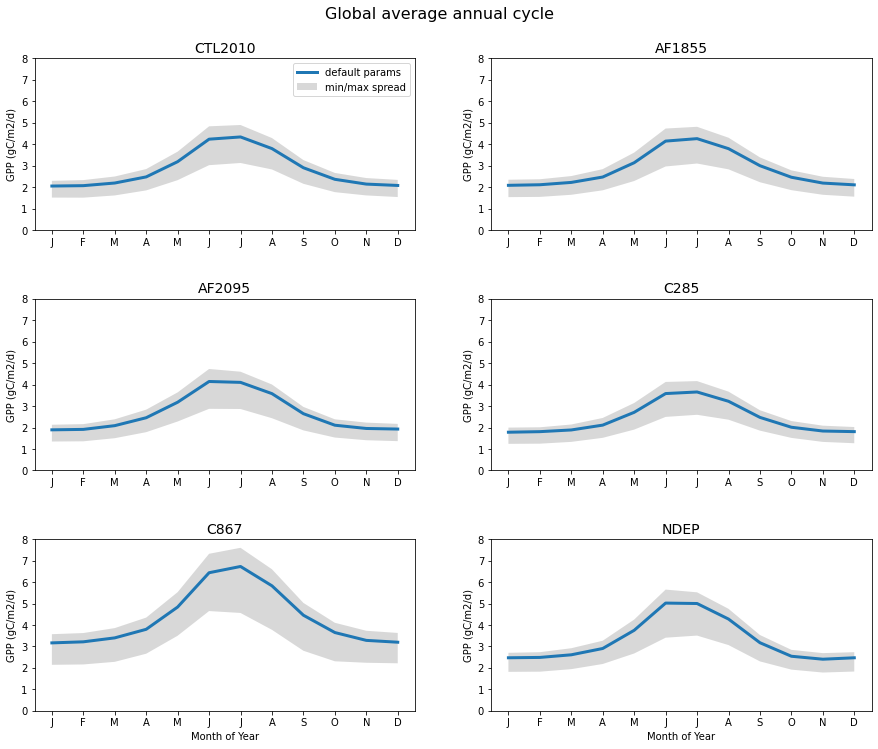

In [110]:
# loop over environmental perturbations and plot
keys  = paramkey.key
htape = 'h0'
#names = ['CTL2010', 'AF2095'] # test 2 to start
names = ['CTL2010', 'AF1855', 'AF2095', 'C285', 'C867', 'NDEP'] # environmental perturbations
nnames = len(names)

# set up panel plot
fig, ax = plt.subplots(3, 2, figsize=(15,12))
axs = ax.ravel()

for n in range(nnames):
    # load the ensemble
    files = get_files(names[n],htape,keys)
    data_vars = ['GPP']
    ds = get_ensemble(files,data_vars,keys,paramkey)
    
    #compute the global annual cycle
    cf1 = 24*60*60    #gc/m2/s -> /d
    cf2 = 1/la.sum()
    units = 'gC/m2/d'
    datavar='GPP'
    x = cf1*cf2*(la*ds[datavar]).sum(dim='gridcell').groupby('time.month').mean()
    
    # calculate min/max ensemble member and persist values for faster subsequent computations
    x_min = x.min(dim='ens').persist()
    x_max = x.max(dim='ens').persist()

    axs[n].plot(x.month, x.sel(ens=0), linewidth=3, label='default params')
    axs[n].fill_between(x.month, x_min, x_max, alpha=0.3, facecolor='grey', label='min/max spread')
    axs[n].set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
    # x label at bottom only
    if n==4 or n==5:
        axs[n].set_xlabel('Month of Year')
    axs[n].set_ylim([0,8])
    axs[n].set_ylabel(datavar+' ('+units+')')
    axs[n].set_title(names[n], fontsize=14)
    # legend on first panel only
    if n==0:
        axs[n].legend()
    
fig.suptitle('Global average annual cycle', fontsize=16, y=0.94);
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig('../figs/compare_climo_monthlymean.png', bbox_inches='tight')

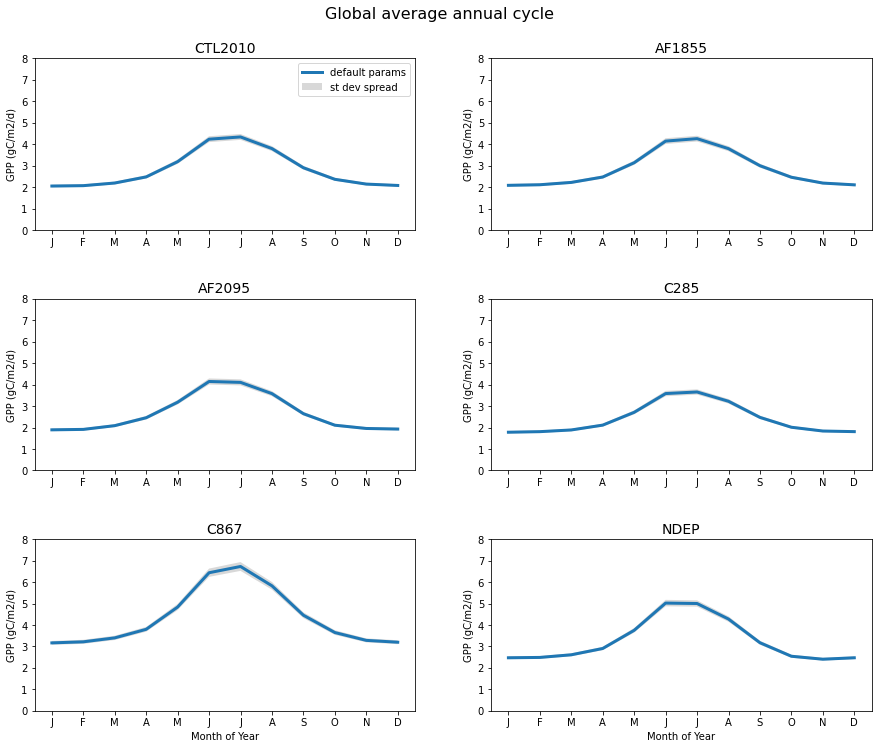

In [111]:
# loop over environmental perturbations and plot - standard deviation version
keys  = paramkey.key
htape = 'h0'
#names = ['CTL2010', 'AF2095'] # test 2 to start
names = ['CTL2010', 'AF1855', 'AF2095', 'C285', 'C867', 'NDEP'] # environmental perturbations
nnames = len(names)

# set up panel plot
fig, ax = plt.subplots(3, 2, figsize=(15,12))
axs = ax.ravel()

for n in range(nnames):
    # load the ensemble
    files = get_files(names[n],htape,keys)
    data_vars = ['GPP']
    ds = get_ensemble(files,data_vars,keys,paramkey)
    
    #compute the global annual cycle
    cf1 = 24*60*60    #gc/m2/s -> /d
    cf2 = 1/la.sum()
    units = 'gC/m2/d'
    datavar='GPP'
    x = cf1*cf2*(la*ds[datavar]).sum(dim='gridcell').groupby('time.month').mean()
    
    # calculate std and persist values for faster subsequent computations
    x_spread = x.std(dim='ens').persist()

    axs[n].plot(x.month, x.sel(ens=0), linewidth=3, label='default params')
    axs[n].fill_between(x.month, x.sel(ens=0)-x_spread, x.sel(ens=0)+x_spread, alpha=0.3, facecolor='grey', label='st dev spread')
    axs[n].set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
    # x label at bottom only
    if n==4 or n==5:
        axs[n].set_xlabel('Month of Year')
    axs[n].set_ylim([0,8])
    axs[n].set_ylabel(datavar+' ('+units+')')
    axs[n].set_title(names[n], fontsize=14)
    # legend on first panel only
    if n==0:
        axs[n].legend()
    
fig.suptitle('Global average annual cycle', fontsize=16, y=0.94);
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig('../figs/compare_climo_monthlymean_stdev.png', bbox_inches='tight')

In [20]:
paramkey.key

0      OAAT0000
1      OAAT0001
2      OAAT0002
3      OAAT0003
4      OAAT0004
         ...   
368    OAAT0460
369    OAAT0461
370    OAAT0469
371    OAAT0470
372    OAAT0471
Name: key, Length: 373, dtype: object

In [12]:
# look at some water flux variables
keys  = paramkey.key
htape = 'h0'
name = 'CTL2010' # test to start
#names = ['CTL2010', 'AF1855', 'AF2095', 'C285', 'C867', 'NDEP'] # environmental perturbations
#nnames = len(names)

# load the ensemble
files = get_files(name,htape,keys)
data_vars = ['QSOIL','QVEGE','QVEGT']
ds = get_ensemble(files,data_vars,keys,paramkey)

In [13]:
ds.QSOIL

<xarray.DataArray 'QSOIL' (ens: 373, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(373, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372
  * time      (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Attributes:
    long_name:     Ground evaporation (soil/snow evaporation + soil/snow subl...
    units:         mm/s
    cell_methods:  time: mean

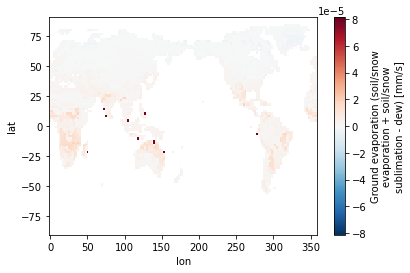

In [19]:
da_map = get_map(ds.QSOIL.isel(ens=0,time=1))
da_map.plot()

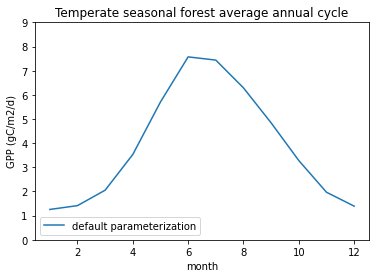

In [33]:
#compute the average annual cycle for a given biome
#biome=1  #tropical rain forest
biome=5  #temperate seasonal forest
bname=str(ds0.biome_name.sel(biome_id=biome).values)
la_biome = la*(ds0.biome==biome)
cf1 = 24*60*60    #gc/m2/s -> /d
cf2 = 1/la_biome.sum()
units = 'gC/m2/d'

datavar='GPP'
x = cf1*cf2*(la_biome*ds[datavar]).sum(dim='gridcell').groupby('time.month').mean()

x.sel(ens=0).plot()
plt.ylim([0,9])
plt.ylabel(datavar+' ('+units+')');
plt.legend(['default parameterization'],loc=3)
plt.title(bname+' average annual cycle');

### Examine param perturbation values

In [14]:
ds.param

<xarray.DataArray 'param' (ens: 373)>
array(['default', 'taulnir', 'taulnir', 'taulvis', 'taulvis', 'tausnir',
       'tausnir', 'tausvis', 'tausvis', 'rholnir', 'rholnir', 'rholvis',
       'rholvis', 'rhosnir', 'rhosnir', 'rhosvis', 'rhosvis', 'xl', 'xl',
       'displar', 'displar', 'dleaf', 'dleaf', 'z0mr', 'z0mr', 'csoilc',
       'csoilc', 'cv', 'cv', 'a_coef', 'a_exp', 'zlnd', 'zlnd', 'zsno',
       'zsno', 'd_max', 'd_max', 'frac_sat_soil_dsl_init',
       'frac_sat_soil_dsl_init', 'lai_dl', 'z_dl', 'z_dl',
       'zetamaxstable', 'zetamaxstable', 'wind_min', 'wind_min',
       'tkd_sand', 'tkd_sand', 'tkd_clay', 'tkd_clay', 'tkd_om', 'tkd_om',
       'tkm_om', 'tkm_om', 'pd', 'pd', 'csol_om', 'csol_om', 'csol_sand',
       'csol_sand', 'csol_clay', 'csol_clay', 'baseflow_scalar',
       'baseflow_scalar', 'maximum_leaf_wetted_fraction',
       'maximum_leaf_wetted_fraction', 'interception_fraction',
       'aq_sp_yield_min', 'fff', 'fff', 'liq_canopy_storage_scalar',
       'liq_canopy_storage_scalar', 'snow_canopy_storage_scalar',
       'snow_canopy_storage_scalar', 'e_ice', 'e_ice', 'n_baseflow',
       'n_melt_coef', 'n_melt_coef', 'accum_factor', 'eta0_vionnet',
       'eta0_vionnet', 'drift_gs', 'drift_gs', 'ssi', 'ssi', 'wimp',
       'wimp', 'upplim_destruct_metamorph', 'upplim_destruct_metamorph',
       'wind_snowcompact_fact', 'rho_max', 'rho_max', 'tau_ref',
...
       'cmb_cmplt_fact_cwd', 'cropfire_a1', 'cropfire_a1',
       'boreal_peatfire_c', 'boreal_peatfire_c', 'non_boreal_peatfire_c',
       'non_boreal_peatfire_c', 'fsr_pft', 'fsr_pft', 'fd_pft', 'fd_pft',
       'prh30', 'prh30', 'ignition_efficiency', 'ignition_efficiency',
       'cc_dstem', 'cc_dstem', 'cc_leaf', 'cc_leaf', 'cc_lstem',
       'cc_lstem', 'cc_other', 'cc_other', 'fm_droot', 'fm_droot',
       'fm_leaf', 'fm_leaf', 'fm_lroot', 'fm_lroot', 'fm_lstem',
       'fm_lstem', 'fm_other', 'fm_other', 'fm_root', 'fm_root',
       'vcmaxha', 'jmaxha', 'jmaxha', 'tpuha', 'lmrha', 'lmrha', 'kcha',
       'kcha', 'koha', 'koha', 'cpha', 'cpha', 'vcmaxhd', 'jmaxhd',
       'jmaxhd', 'tpuhd', 'tpuhd', 'lmrhd', 'vcmaxse_sf', 'jmaxse_sf',
       'tpuse_sf', 'tpuse_sf', 'jmax25top_sf', 'jmax25top_sf', 'KCN',
       'KCN', 'LF', 'LF', 'FR', 'FR', 'Q10', 'Q10', 'CWD', 'CWD',
       'om_frac_sf', 'slopebeta', 'slopebeta', 'slopemax', 'slopemax',
       'pc', 'mu', 'mu', 'C2_liq_Brun89', 'C2_liq_Brun89', 'om_frac_sf',
       'medlynslope', 'medlynintercept', 'jmaxb0', 'wc2wjb0', 'q10_mr',
       'vcmaxha', 'tpuha', 'lmrse', 'jmaxse_sf', 'lmrhd', 'vcmaxse_sf',
       'vcmaxhd', 'sand_pf', 'sand_pf', 'clay_pf', 'clay_pf',
       'zbedrock_sf', 'zbedrock_sf', 'decomp_depth_efolding'],
      dtype='<U32')
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372

In [15]:
param = 'decomp_depth_efolding'
ix = ds.param==param
params = ['default',*ds.param.isel(ens=ix).values]
print(params)
minmax = ['default',*ds.minmax.isel(ens=ix).values]
print(minmax)

['default', 'decomp_depth_efolding']
['default', 'min']


In [16]:
keys = ds.key.isel(ens=ix).values
print(keys)

['OAAT0471']


In [25]:
## if you want to examine the actual values of a given param
#param = 'jmaxb1'
#param = 'decomp_depth_efolding' # bug here - min should be 0.3? I think decomp_depth_efolding is on default paramfile (0AAT000.nc) and so the logic to pull the namelist mod value isn't triggering
#param = 'a_coef' # max equal to default
param = 'a_exp' # min equal to default

## shouldn't need to edit below

ix = ds.param==param
params = ['default',*ds.param.isel(ens=ix).values]
minmax = ['default',*ds.minmax.isel(ens=ix).values]

ix = ds.ens>np.inf
for p,m in zip(params,minmax):
    ix = (ix)|((ds.param==p)&(ds.minmax==m))

keys = ds.key.isel(ens=ix).values
pvals = []
pdir = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
lndin = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
#print(keys,params)
for key,p in zip(keys,params):
    #print(key)
    pf = xr.open_dataset(pdir+key+'.nc')
    #print(param)
    if param in pf.data_vars:
        pvals.append(pf[param].values)
    else:
        nfile = ndir+key+'.txt'
        if p=='default':
            cmd = 'grep '+param+' '+lndin
            tmp = os.popen(cmd).read().split()[2]
            if 'd' in tmp:
                tmp = tmp.split('d')
                pval = float(tmp[0])*10**float(tmp[1])
            else:
                pval = float(tmp)
        else:
            with open(nfile) as f:
                lines = f.readlines()
                pval = float(lines[1].split('=')[1].split('\n')[0])
                #print(pval)
        pvals.append(pval)
### note that default may also serve as min or max
for i,m in enumerate(minmax):
    print(param,m,pvals[i])

a_exp default 0.45
a_exp max 0.5


### examine a sample file
- useful for checking which variables are available

In [56]:
h0 = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0400.clm2.h0.2005-02-01-00000.nc'
ds0 = xr.open_dataset(h0)
ds0.data_vars

Data variables: (12/497)
    mcdate                             (time) int32 ...
    mcsec                              (time) int32 ...
    mdcur                              (time) int32 ...
    mscur                              (time) int32 ...
    nstep                              (time) int32 ...
    time_bounds                        (time, hist_interval) object ...
    ...                                 ...
    XSMRPOOL                           (time, gridcell) float32 ...
    XSMRPOOL_RECOVER                   (time, gridcell) float32 ...
    ZBOT                               (time, gridcell) float32 ...
    ZWT                                (time, gridcell) float32 ...
    ZWT_CH4_UNSAT                      (time, gridcell) float32 ...
    ZWT_PERCH                          (time, gridcell) float32 ...

In [57]:
h5 = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0400.clm2.h5.2005-01-01-00000.nc'
ds5 = xr.open_dataset(h5)
ds5.data_vars

Data variables: (12/89)
    mcdate              (time) int32 ...
    mcsec               (time) int32 ...
    mdcur               (time) int32 ...
    mscur               (time) int32 ...
    nstep               (time) int32 ...
    time_bounds         (time, hist_interval) object ...
    ...                  ...
    TSOI_10CM           (time, gridcell) float32 ...
    TV                  (time, gridcell) float32 ...
    TWS                 (time, gridcell) float32 ...
    VEGWPLN             (time, nvegwcs, gridcell) float32 ...
    VEGWPPD             (time, nvegwcs, gridcell) float32 ...
    VPD_CAN             (time, gridcell) float32 ...

## TO DO: interactive plots (holoviews?), host online (jupyter book?)